In [1]:
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time



## Parameters and Basic settings

In [2]:
E = 10.
nu = 0.3
G = E/(2*(1+nu))
Force = 1.
seed_id = 1234
lr = 4e-3
nneurons = 70
nhiden_layers = 4
Nf_x = 50 # Number of collocation points in x direction
Nf_y = 20 # Number of collocation points in y direction
N_bc = 30 # Number of boundary points
device = 'cuda'

print(type(G))

# Set default dtype to float32
torch.set_default_dtype(torch.float)
# PyTorch random number generator
torch.manual_seed(seed_id)
# Random number generators in other libraries
np.random.seed(seed_id)

<class 'float'>


## Normalization

In [3]:
def normalize(X_tensor, X_min, X_max):
    """
    Normalize a tensor by columns given a max and min of each column.
    
    Parameters:
    X_tensor(numpy array): Tensor to be normalized.
    """
    # Normalize input vector X by each feature
    (num_row_X, num_col_X) = X_tensor.shape
    normalized_X_tensor = torch.zeros_like(X_tensor)
    
    # Fill the copy vector
    for col in range(num_col_X):
        min_X_col = X_min[col]
        max_X_col = X_max[col]
        normalized_X_tensor[:,col] = (X_tensor[:,col]-min_X_col)*2/(max_X_col-min_X_col) -1
        
    return normalized_X_tensor

def unnormalize(X_tensor, X_min, X_max):
    """
    Unnormalize a tensor by columns given a max and min of each column.
    
    Parameters:
    X_tensor(numpy array): Tensor to be unnormalized.
    X_max(numpy array): Max of each column of the tensor to be unnormalized.
    X_min(numpy array): Min of each column of the tensor to be unnormalized.
    """
    # Unnormalize input vector X by each feature
    (num_row_X, num_col_X) = X_tensor.shape
    unnormalized_X_tensor = torch.zeros_like(X_tensor)
    
    # Fill the copy vector
    for col in range(num_col_X):
        unnormalized_X_tensor[:,col] = (X_tensor[:,col]+1)*(X_max[col]-X_min[col])/2 + X_min[col]
        
    return unnormalized_X_tensor

## Loading data

In [4]:
displacement_data_path = "../LinearElasticPlate/PlaneStress/data/Displacement.csv"                      # path to displacement data
stress_data_path = "../LinearElasticPlate/PlaneStress/data/Stress.csv"                                  # path to stress data
ititialPosition_data_path = "../LinearElasticPlate/PlaneStress/data/InitialPosition.csv"                # path to initial position data
displacement_header= ['Node','u','v','w']                               # header of displacement data
stress_header = ['Node','s11','s22','s33','s12','s23','s13']            # header of stress data
initialPosition_header = ['Node','x','y','z']                           # header of initial position data

displacement_df = pd.read_csv(displacement_data_path,header=None)       # Reading data
displacement_df.columns = displacement_header                           # Assigning column names
stress_df = pd.read_csv(stress_data_path,header=None)                   # Reading data
stress_df.columns = stress_header                                       # Assigning column names
initialPosition_df = pd.read_csv(ititialPosition_data_path,header=None) # Reading data
initialPosition_df.columns = initialPosition_header                     # Assigning column names

# Extracting data

fields_u = ['u','v']                                                    # Not considering the z component
fields_s = ['s11']                                                      # Not considering the other components
fields_x = ['x','y']                                                    # Not considering the z component
fields_x_extended = ['x','y','z']                                       # Considering the z component

X_real = initialPosition_df[fields_x].to_numpy()                        # Just the x,y coordinates  
X_real = np.unique(X_real.round(decimals=2), axis=0)                    # Remove duplicates
X_real = X_real.astype(np.float32)                                      # Convert to float32
X_real = torch.from_numpy(X_real).to(device)                                       # Convert to tensor

X_real_extended = initialPosition_df[fields_x_extended].to_numpy()      # All the coordinates
X_real_extended = np.unique(X_real_extended.round(decimals=2), axis=0)  # Remove duplicates
X_real_extended = X_real_extended.astype(np.float32)                    # Convert to float32
X_real_extended = torch.from_numpy(X_real_extended).to(device)                     # Convert to tensor

# # Geometrical bounds
left_b = min(X_real_extended[:,0])
right_b = max(X_real_extended[:,0])
bottom_b = min(X_real_extended[:,1])
top_b = max(X_real_extended[:,1])
front_b = max(X_real_extended[:,2])
back_b = min(X_real_extended[:,2])
height = top_b - bottom_b
depth = front_b - back_b
length = right_b - left_b
A_front = depth*height 
X_min = torch.tensor([left_b, bottom_b, back_b]).to(device)
X_max = torch.tensor([right_b, top_b, front_b]).to(device)
print('The boundaries are: left =',left_b,'right =',right_b,'bottom =',bottom_b,'top =',top_b, 'front =',front_b, 'back =',back_b)
print("The applied force is:",Force, "over an area of:",A_front, "resulting in a stress of:",Force/A_front)

# Obtaining the displacement data
U_real = displacement_df[fields_u].to_numpy()                           # Just the u,v components
U_real = np.unique(U_real.round(decimals=3), axis=0)                    # Remove duplicates
U_real = U_real.astype(np.float32)                                      # Convert to float32
U_real = torch.from_numpy(U_real).to(device)                                       # Convert to tensor

# Obtaining the stress data
S_real = stress_df[fields_s].to_numpy()                                 # Just the s11 component
S_real = np.unique(S_real.round(decimals=2), axis=0)                    # Remove duplicates
S_real = S_real.astype(np.float32)                                      # Convert to float32
S_real = torch.from_numpy(S_real).to(device)                                       # Convert to tensor


The boundaries are: left = tensor(-15., device='cuda:0') right = tensor(15., device='cuda:0') bottom = tensor(-5., device='cuda:0') top = tensor(5., device='cuda:0') front = tensor(1., device='cuda:0') back = tensor(0., device='cuda:0')
The applied force is: 1.0 over an area of: tensor(10., device='cuda:0') resulting in a stress of: tensor(0.1000, device='cuda:0')


## Collocation points and auxiliary vectors

In [12]:
## Collocation points for PDF
X_f = np.random.uniform(left_b, right_b, (Nf_x, 1))                     # Random points in x direction
Y_f = np.random.uniform(bottom_b, top_b, (Nf_y, 1))                     # Random points in y direction
comb_array = np.array(np.meshgrid(X_f, Y_f)).T.reshape(-1, 2)           # Combine the two arrays
X_train_f = torch.tensor(comb_array).to(device)                         # Convert to tensor the collocation points

# Collocation point for BC
distance = height/(N_bc-1)
X_bc_y = torch.linspace(bottom_b+distance/2, top_b-distance/2, N_bc).reshape(N_bc,1)        # Equispaced points in y direction
X_bc_x = torch.ones(N_bc)*torch.max(X_real[:,0])                                            # Boundary conditions indexes
X_bc_x = X_bc_x.reshape(N_bc,1)                                                             # Reshape
X_bc = torch.concatenate((X_bc_x, X_bc_y), axis=1).to(device)                                          # Combine the two arrays

s_x = Force/A_front
Stress_bc = torch.ones_like(X_bc[:,0])*s_x

f_hat = torch.zeros(Nf_x*Nf_y, 2).to(device)
print("The number of collocation points for the PDE is:",Nf_x*Nf_y)
print("The number of collocation points for the BC is:", N_bc)

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

Estan poniendo como condición de contorno un stress. Es decir, que estamos dividiendo la fuerza aplicada por la superficie de aplicación para así tener una presión, que será el esfuerzo sobre cada nodo. Si por el contrario, aplicamos una fuerza sobre cada nodo de X newtons, lo que necesitamos en teoria es o la tension o la fuerza por volumen, tengo que aclararme con esto.   

Tenemos que poner las condicione de contorno para los nodos, en este caso, serán la tension en los de la frontera presionada, y 0 para el resto de collocation points.   

In [6]:
plt.scatter(X_train_f.numpy()[:,0],X_train_f.numpy()[:,1])

NameError: name 'X_train_f' is not defined

In [7]:
input_dim = X_real.shape[1]
output_dim = U_real.shape[1]
layers = np.array([input_dim] + [ nneurons for i in range(nhiden_layers)] + [output_dim])
layers

array([ 2, 70, 70, 70, 70,  2])

## Deep NN class

In [8]:
#  Deep Neural Network
class DNN(nn.Module):
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Tanh()
    
        'Initialize neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers) - 1)])
    
        'Xavier Normal Initialization'
        for i in range(len(layers)-1):
            
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)
            
    'foward pass'
    def forward(self,x):
              
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)             

        xn = normalize(x, X_min, X_max)         # Normalize the input

        #convert to float
        a = xn.float()

        # inpunt and hidden layers forward computation
        for i in range(len(layers)-2):
            
            z = self.linears[i](a)
                        
            a = self.activation(z)

        # output layer forward computation            
        a = self.linears[-1](a)
        
        return a

## PINN class

In [9]:
class PINN():
    def __init__(self, layers,pde_type=0):
        
        'Define loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        'Initialize iterator'
        self.iter = 0
        
        # 'Initialize our new parameter G, N, ec, eg as tensor (Inverse problem)' 
        # self.G = torch.tensor([float(G_init)], requires_grad=True).float().to(device)  
                
        # 'Register parametes to be optimized'
        # self.G = nn.Parameter(self.G)

        'Initialize our DNN'
        self.dnn = DNN(layers).to(device)
        
        # 'Register our new parameter'
        # self.dnn.register_parameter('G', self.G)  

        'History of losses'
        self.loss_history = {"Data": [],
                             "PDE": [],
                             "BC": [],
                             "Total":[]}
        
        # 'Parameters trials'
        # self.params_history = {"G": [] }

    def loss_data(self, x, u_real, save = False):

        
        u_nn = self.dnn(x)
     
        loss_d = self.loss_function(u_nn, u_real)
        
        save and self.loss_history["Data"].append(loss_d.to('cpu').detach().numpy()) 
        
        return loss_d
        
    def loss_PDE(self, pos_f, save = False):
                       
        # clone the input data and add AD
       
        pos = pos_f.clone()
        pos.requires_grad = True

        # predict u
        U = self.dnn(pos)

        # compute the derivatives togheter
        dU = autograd.grad(U, pos, torch.ones([pos.shape[0], 2]).to(device),retain_graph=True, create_graph=True)[0]

        u_x = dU[:,0].reshape(-1,1)
        v_y = dU[:,1].reshape(-1,1)

        U_shifted = torch.roll(U, 1, 1)
        dU_shifted_1 = autograd.grad(U_shifted, pos, torch.ones([pos.shape[0], 2]).to(device),retain_graph=True, create_graph=True)[0]
        v_x = dU_shifted_1[:,0].reshape(-1,1)
        u_y = dU_shifted_1[:,1].reshape(-1,1)



        # compute second derivatives
        ddU = autograd.grad(dU, pos, torch.ones([pos.shape[0], 2]).to(device),retain_graph=True, create_graph=True)[0]

        u_xx = ddU[:,0].reshape(-1,1)
        v_yy = ddU[:,1].reshape(-1,1)

        # Shift columns of du tensor
        dU_shifted_2 = torch.roll(dU, 1, 1)

        cross_ddU = autograd.grad(dU_shifted_2, pos, torch.ones([pos.shape[0], 2]).to(device),retain_graph=True, create_graph=True)[0]

        u_xy = cross_ddU[:,1].reshape(-1,1)
        v_yx = cross_ddU[:,0].reshape(-1,1)

        ddU_shifted_1 = autograd.grad(dU_shifted_1, pos, torch.ones([pos.shape[0], 2]).to(device),retain_graph=True, create_graph=True)[0]

        u_yy = ddU_shifted_1[:,0].reshape(-1,1)
        v_xx = ddU_shifted_1[:,1].reshape(-1,1)



        # PDE f = 0
        # if pde_type==0:
        #     f = [ (2*G)/(1-nu) * (u_xx + nu*v_yx) + G*(u_xy+ v_yy) ,  
        #           G*(u_xx + v_yx) + (2*G)/(1-nu)*(v_yy + nu*u_xy) ]
        # elif pde_type==1:
        f= [ (2*G/(1-nu)*( u_xx + nu* v_yx )) + G* ( u_yy + v_yx),
            (2*G/(1-nu)*( v_yy + nu* u_xy )) + G* ( v_xx + u_xy)]
        f_tensor= torch.cat((f[0] , f[1]), dim=1).to(torch.float32)

        
        # f_hat is just an auxiliar term to copmute the loss (is zero)
        loss_f = self.loss_function(f_tensor, torch.zeros_like(f_tensor) )

        save and self.loss_history["PDE"].append(loss_f.to('cpu').detach().numpy()) 
        return loss_f


    def loss_BC(self, pos_bc, save = False):
        
        # clone the input data and add AD
        pos = pos_bc.clone()
        pos.requires_grad = True
        
        # predict U
        U = self.dnn(pos)
        
        # compute the derivatives togheter
        dU = autograd.grad(U, pos, torch.ones([pos.shape[0], 2]).to(device), retain_graph=True, create_graph=True)[0]
        u_x = dU[:,0].reshape(-1,1)
        v_y = dU[:,1].reshape(-1,1)

        # compute s11_pred
        s11_pred = (2*G)/(1-nu) * (u_x + nu*v_y)

        loss_bc = self.loss_function(s11_pred, Stress_bc)
        
        save and self.loss_history["BC"].append(loss_bc.to('cpu').detach().numpy()) 

        return loss_bc


    def loss(self, pos_real, despl_real, pos_f, pos_bc, save = False):

        loss_d  = self.loss_data(pos_real, despl_real, save)
        loss_f  = self.loss_PDE( pos_f, save)
        loss_bc = self.loss_BC(pos_bc, save)
        
        # weights should sum 1
        loss_val = loss_d  + loss_f + loss_bc

        if save:
            self.loss_history["Total"].append(loss_val.to('cpu').detach().numpy())
        return loss_val


    'callable for optimizer'                                       
    def closure(self):
        
        optimizer.zero_grad()
        
        loss = self.loss(X_real, U_real, X_train_f, X_bc, True)
        
        loss.backward()
        
        self.iter += 1

        print(
            'LBFGS iter: %d, Loss error(Train): %.10f ' %
            (   
                self.iter,
                loss.cpu().detach().numpy(),
            )
        )

        
        return loss        
    
    'foward pass'
    def forward(self,pos):
        return self.dnn(pos)

In [10]:
'Neural Network Summary'
pinn_LBFGS = PINN(layers)

'Neural Network Parameters'
params = list(pinn_LBFGS.dnn.parameters())

'Mesure time'
start_time = time.time()

'L-BFGS Optimizer'
optimizer = torch.optim.LBFGS(params, lr, 
                              max_iter = 100, 
                              max_eval = None, 
                              tolerance_grad = 1e-7, 
                              tolerance_change = 1e-7, 
                              line_search_fn = 'strong_wolfe',
                              history_size = 100)

optimizer.step(pinn_LBFGS.closure)

elapsed_time_LBFGS = time.time() - start_time
print('Elapsed time: %.10f seconds.' % elapsed_time_LBFGS)

NameError: name 'X_train_f' is not defined

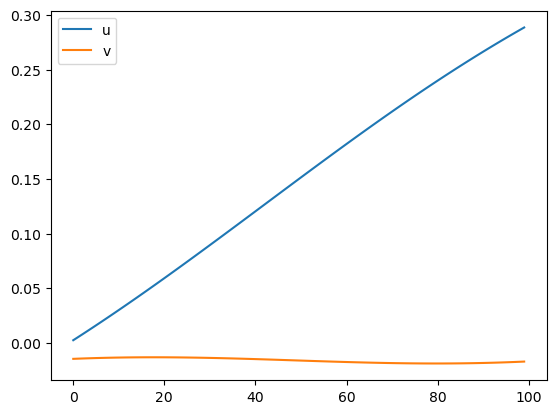

In [11]:
# Creating a tensor array named X_test with two entries, X_test_1 from 0 to 30, and X_test_2 equal to 0
X_test_1 = torch.linspace(-15, 15, 100).reshape(-1,1)
X_test_2 = torch.zeros(100).reshape(-1,1)*-2 #pongo esto para que sea una se las caras
X_test = torch.cat((X_test_1, X_test_2), dim=1)

U = pinn_LBFGS.forward(X_test)

# convert U[:,0] and U[:,1] to numpy arrays
u = U[:,0].cpu().detach().numpy()
v = U[:,1].cpu().detach().numpy()

# plot  u and v
plt.plot(u, label='u')
plt.plot(v, label='v')
plt.legend()
plt.show()


???¿?
No entiendo porque lo de y en negativo es algo bueno, si el 0 es la parte intermedia, lo esperado de esto, sería que no hubiera desplazamiento, mientras que en las caras sí.  

## Verification

In [12]:
delta_x = Force*length/E/A_front
print("delta_x is:", delta_x)
epsilon_x = delta_x/length
epsilon_y = -nu*epsilon_x
delta_y = epsilon_y*height/2
print("delta_y is:", delta_y)

print("Coeficiente de posion:",nu)

print("Desplazamiento segun y calculado:" , U.mean(axis=0)[1])##esta bien esto ?

delta_x is: tensor(0.3000)
delta_y is: tensor(-0.0150)
Coeficiente de posion: 0.3
Desplazamiento segun y calculado: tensor(-0.0158, grad_fn=<SelectBackward0>)


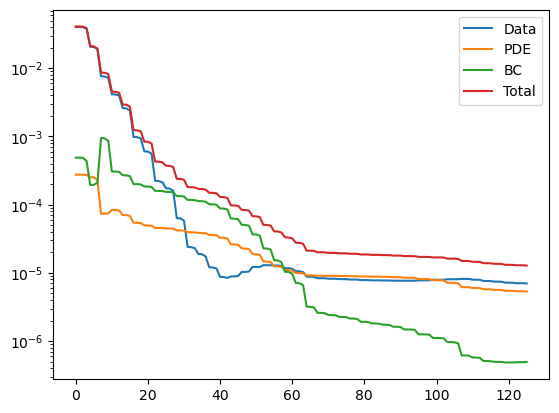

<Figure size 640x480 with 0 Axes>

In [13]:
# print los history with log scale
plt.plot(pinn_LBFGS.loss_history["Data"], label='Data')
plt.plot(pinn_LBFGS.loss_history["PDE"], label='PDE')
plt.plot(pinn_LBFGS.loss_history["BC"], label='BC')
plt.plot(pinn_LBFGS.loss_history["Total"], label='Total')
plt.yscale('log')
plt.legend()
plt.show()
plt.savefig('PINN_LEP_Losses.png')

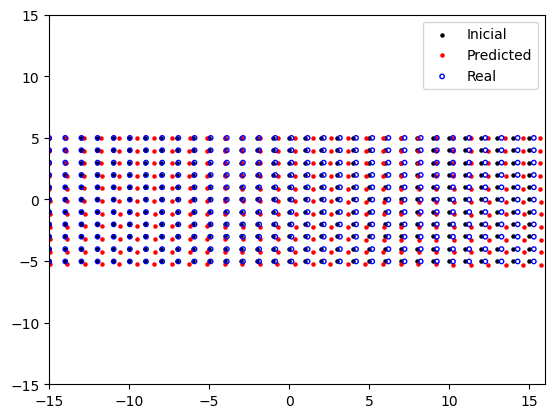

<Figure size 640x480 with 0 Axes>

In [17]:
# Plot mesh of displacements and original position in red and blue respectively
U_predicted = pinn_LBFGS.forward(X_real).to('cpu').detach().numpy()
X_final_pred = X_real + U_predicted*10
X_final_real = X_real + U_real.to('cpu').detach().numpy()
plt.figure()
plt.scatter(X_real[:,0], X_real[:,1], c='k', label='Inicial', s=5)
plt.scatter(X_final_pred[:,0], X_final_pred[:,1], c='r', label='Predicted', s=5)
plt.scatter(X_final_real[:,0], X_final_real[:,1], edgecolors='b', facecolors='none', label='Real', s=10)
plt.xlim(-15, 16)
plt.ylim(-15, 15)
plt.legend(loc='best')
plt.show()
plt.savefig('PINN_LEP_Configuration.png')

(array([11.,  6.,  6., 10.,  7.,  5., 13., 12., 13., 11.,  6., 11., 10.,
         5.,  3.,  7., 11.,  4.,  6.,  6.,  8.,  1.,  8.,  6.,  7.,  9.,
         1.,  2., 10.,  9.,  6.,  3.,  4.,  7., 13.,  4.,  4.,  5., 16.,
         5.,  6., 13., 10., 11.,  5.,  1.,  1.,  1.,  1.,  1.]),
 array([-0.02868668, -0.02807228, -0.02745789, -0.0268435 , -0.0262291 ,
        -0.02561471, -0.02500032, -0.02438592, -0.02377153, -0.02315714,
        -0.02254274, -0.02192835, -0.02131396, -0.02069956, -0.02008517,
        -0.01947078, -0.01885638, -0.01824199, -0.01762759, -0.0170132 ,
        -0.01639881, -0.01578442, -0.01517002, -0.01455563, -0.01394124,
        -0.01332684, -0.01271245, -0.01209806, -0.01148366, -0.01086927,
        -0.01025487, -0.00964048, -0.00902609, -0.0084117 , -0.0077973 ,
        -0.00718291, -0.00656852, -0.00595412, -0.00533973, -0.00472534,
        -0.00411094, -0.00349655, -0.00288215, -0.00226776, -0.00165337,
        -0.00103897, -0.00042458,  0.00018981,  0.00080421,

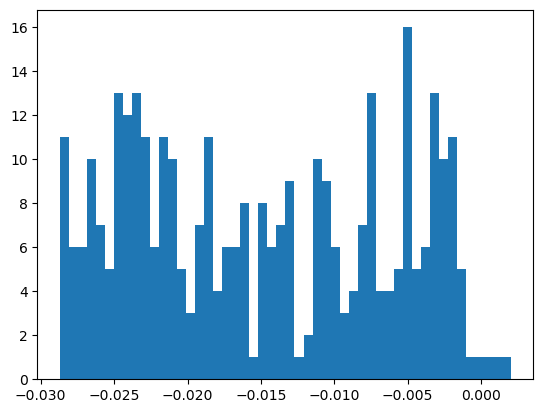

In [15]:
plt.hist(U_predicted[:,1],bins=50)

In [43]:
aux_color=X_real[:,1].detach().numpy()>0


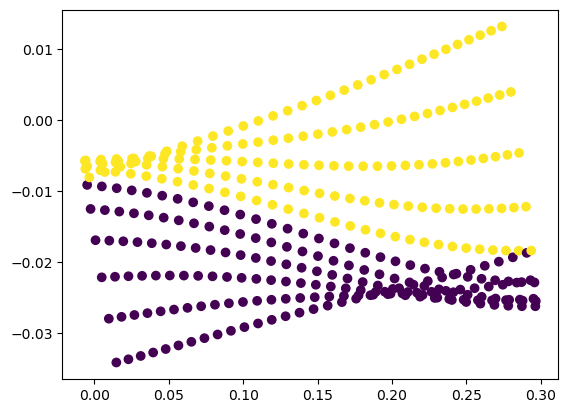

In [44]:
plt.scatter(U_predicted[:,0],U_predicted[:,1],c=aux_color.astype(int))

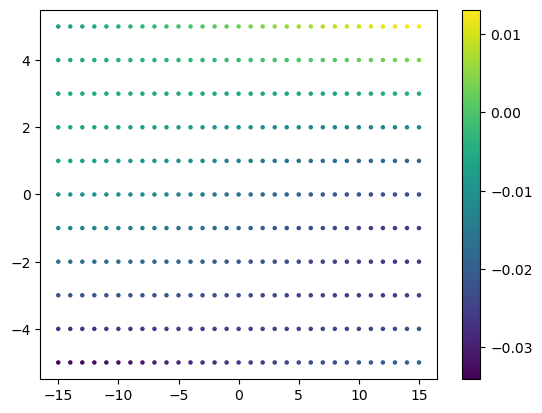

In [58]:
plt.scatter(X_real[:,0], X_real[:,1], c=U_predicted[:,1], label='Inicial', s=5)
plt.colorbar()

Esto no tiene sentido, debería ser simétrico con Y aqui. 

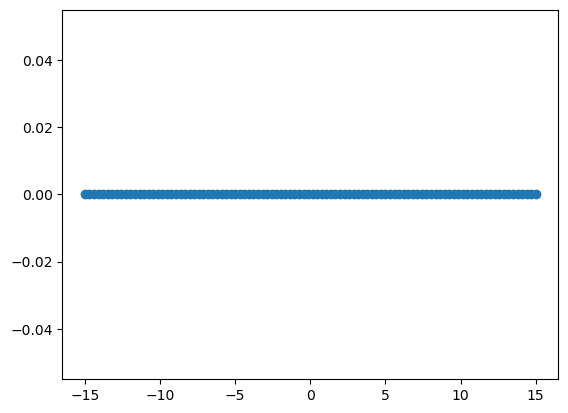

In [20]:
aux=X_test.detach().numpy()
plt.scatter(aux[:,0],aux[:,1])